## Part-II: Implementation of Encoder-Decoder using RNN / 
LSTM 

## Objective: 
To implement a simple encoder-decoder model for sequence tasks like 
translation or summarization using TensorFlow


# Assignment Tasks 
# Task 3: Data Preparation for Sequence Learning 
● Use a toy dataset or download an English-to-French translation 
dataset (e.g., from http://www.manythings.org/anki/). 
● Preprocess the text: 
○ Tokenize input and output sequences 
○ Pad sequences for batching 
○ Prepare input_tensor, target_tensor

In [3]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

In [19]:
path = open('eng-to-french/fra.txt', 'r', encoding='utf-8').read().split('\n')

In [9]:
# for line in path[:10]:
#     print(line)

In [ ]:
sentence_pairs = [line.split('\t')[:2] for line in path if line.strip() != '' and len(line.split('\t')) >= 2 and len(line.split('\t')[0]) > 0 and len(line.split('\t')[1]) > 0 ]
english_sentences, french_sentences = zip(*sentence_pairs)


In [21]:
french_sentences = ['<start> ' + sent + ' <end>' for sent in french_sentences]

In [22]:
def tokenize(lang_sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(lang_sentences)
    tensor = tokenizer.texts_to_sequences(lang_sentences)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

input_tensor, inp_tokenizer = tokenize(english_sentences)
target_tensor, targ_tokenizer = tokenize(french_sentences)

In [23]:
# Step 5: Check shapes
print(f"Input Tensor Shape: {input_tensor.shape}")
print(f"Target Tensor Shape: {target_tensor.shape}")

Input Tensor Shape: (237838, 55)
Target Tensor Shape: (237838, 58)


In [24]:
embedding_dim = 128
lstm_units = 256
vocab_inp_size = len(inp_tokenizer.word_index) + 1
vocab_tar_size = len(targ_tokenizer.word_index) + 1
max_length_input = input_tensor.shape[1]
max_length_target = target_tensor.shape[1]

In [25]:
# ENCODER
encoder_input = Input(shape=(None,))
enc_emb = Embedding(vocab_inp_size, embedding_dim)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

In [26]:
# DECODER
decoder_input = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_tar_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_input)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_tar_size, activation='softmax')
output = decoder_dense(decoder_output)

In [27]:
model = Model([encoder_input, decoder_input], output)

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  3,965,952 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  7,023,744 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 14,102,361 │ lstm_1[0][0]      │
│                     │ 54873)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,880,537 (98.73 MB)

 Trainable params: 25,880,537 (98.73 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
decoder_input_data = target_tensor[:, :-1]
decoder_target_data = target_tensor[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1) 

In [32]:
sample_size = 1000

input_tensor_small = input_tensor[:sample_size]
decoder_input_data_small = decoder_input_data[:sample_size]
decoder_target_data_small = decoder_target_data[:sample_size]

history = model.fit(
    [input_tensor_small, decoder_input_data_small],
    decoder_target_data_small,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1221s 93s/step - loss: 10.2991 - val_loss: 6.0770
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1018s 80s/step - loss: 4.3332 - val_loss: 0.7427
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 971s 76s/step - loss: 0.5712 - val_loss: 0.6049
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8674s 719s/step - loss: 0.4923 - val_loss: 0.5807
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40422s 3356s/step - loss: 0.4529 - val_loss: 0.5447
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36277s 3017s/step - loss: 0.4032 - val_loss: 0.4993
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1517s 120s/step - loss: 0.3537 - val_loss: 0.4654
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1159s 91s/step - loss: 0.3287 - val_loss: 0.4399
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1035s 81s/step - loss: 0.3176 - val_loss: 0.4307
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 953s 75s/step - loss: 0.3045 - val_loss: 0.4196


In [34]:
model.save("eng-to-fra_translation_model.keras") 

In [36]:
encoder_model = Model(encoder_input, encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_input)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_input] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [37]:
def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = targ_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = targ_tokenizer.index_word.get(sampled_token_index, '')

        if (sampled_word == '<end>' or len(decoded_sentence.split()) > max_length_target):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]
        
    return decoded_sentence.strip()


In [38]:
def evaluate(sentence):
    sentence_seq = inp_tokenizer.texts_to_sequences([sentence])
    sentence_seq = pad_sequences(sentence_seq, maxlen=max_length_input, padding='post')
    return decode_sequence(sentence_seq)

In [40]:
sentence = "hello"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
📝 Input   : hello
🔁 Output  : 


In [39]:
sentence = "what is your name?"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
📝 Input   : what is your name?
🔁 Output  : 


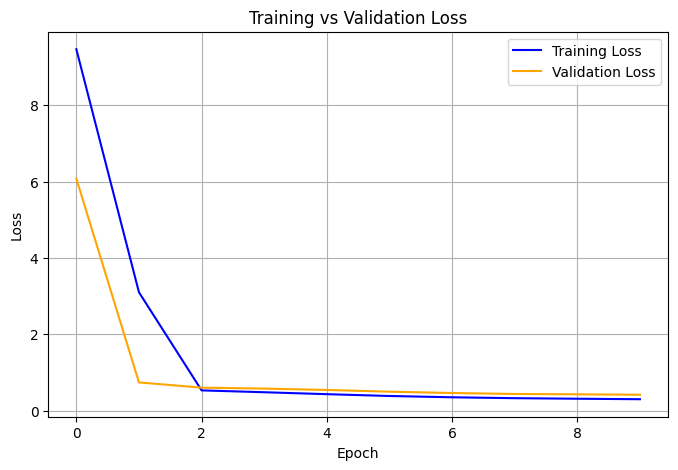

In [41]:

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Task 8: Model Performance Discussion 


### 1. What are the challenges in training sequence-to-sequence models? 


### Ans: Sequence-to-sequence (Seq2Seq) models, especially those built using RNNs or LSTMs, are powerful but come with several practical and theoretical difficulties:
* Vanishing Gradient Problem
* Data Sparsity & Long Sequences
* Decoder Dependency
* Slow Training and Inference

### 2. What does a “bad” translation look like? Why might it happen? 

 ### Ans:
 * Grammatically incorrect

* Semantically nonsensical

* Missing or mistranslating key information

* Overly literal or awkwardly phrased

### 3. How can the model be improved further? 

### Ans: 
* 1. Add an Attention Mechanism
* 2. Use Bidirectional RNNs in the Encoder
* 3. Train on More Data and Larger Vocabulary
* 4. Experiment with Beam Search or Sampling During Inference
* 5. Switch to Transformer Architecture

In [42]:
model.save("eng-to-fra_translation_model2.keras") 